In [1]:
from datetime import datetime
import pandas_datareader.data as wb
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# train 기간 
start = datetime(2018, 5, 3)
end = datetime(2019, 5, 1)

# 예측 기간
y_start = datetime(2019,5,2)
y_end = datetime(2019,5,27)

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## 3. 비정상성 데이터 정상성 데이터로 변환(차분)
non stationary data-> stationary data
1. **차분**
  - 차이값(diff) : 이전 데이터와의 차이값
> - 데이터의 차수를 줄여 정적(Stationary)에 가깝게 한다.(차수 낮춰줌)   
> - 1차항(X=a+b*t)을 상수항(X=b)으로 2차항을 1차항으로 변환된다   
> - (1차 차분)= x(t)-x(t-1)     

2. 로그(log)를 이용한 변환
 - When? 데이터의 진폭이 시간에 따라 증가할때
 
3. Box-Cox transformation

In [2]:
ss = wb.DataReader('005930.KS', 'yahoo', start, end)
ss_y = wb.DataReader('005930.KS', 'yahoo', y_start, y_end)
ss[ss["Volume"]==0]
ss.loc[ss['Volume'] == 0, 'Volume'] = ss['Volume'].median()

# date index에서 빼오기,,
ss.reset_index(inplace=True)
ss_y.reset_index(inplace=True)
print(ss.shape, ss_y.shape)

(241, 7) (17, 7)


In [3]:
ss.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-05-03,53000.0,53000.0,53000.0,53000.0,10638766.0,51733.824219
1,2018-05-04,53900.0,51800.0,53000.0,51900.0,39565391.0,50660.105469
2,2018-05-08,53200.0,51900.0,52600.0,52600.0,23104720.0,51343.382812


## train set 차분

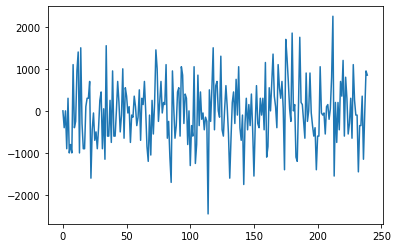

In [4]:
# 차분
y = ss['Open']

b=[]
for i in range(len(y)-1):
    b.append(y[i+1]-y[i])
plt.plot(b)
plt.show()

In [6]:
ss = ss.drop(index=0).reset_index()

In [9]:
ss.head(1)

,index,Date,High,Low,Open,Close,Volume,Adj Close
0,1,2018-05-04,53900.0,51800.0,53000.0,51900.0,39565391.0,50660.105469


In [14]:
ss['new_open'] = b
ss.drop(columns=['Date', 'index', 'Open'], inplace=True)
ss.head()

,High,Low,Close,Volume,Adj Close,new_open
0,53900.0,51800.0,51900.0,39565391.0,50660.105469,0.0
1,53200.0,51900.0,52600.0,23104720.0,51343.382812,-400.0
2,52800.0,50900.0,50900.0,16128305.0,49683.992188,0.0
3,51700.0,50600.0,51600.0,13905263.0,50367.269531,-900.0
4,52200.0,51200.0,51300.0,10314997.0,50074.437500,300.0


## test set 차분

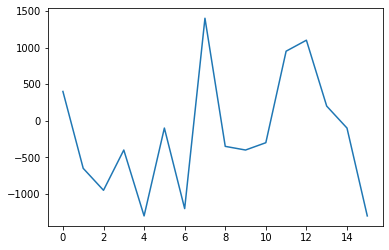

In [15]:
y = ss_y['Open']

b=[]
for i in range(len(y)-1):
    b.append(y[i+1]-y[i])
plt.plot(b)
plt.show()

In [17]:
ss_y = ss_y.drop(index=0).reset_index()
ss_y['new_open'] = b
ss_y.drop(columns=['Date', 'index', 'Open'], inplace=True)
ss_y.head()

,High,Low,Close,Volume,Adj Close,new_open
0,46050,45300,45300,6562916,45300,400
1,45300,44400,44850,12014907,44850,-650
2,44850,44200,44250,10398754,44250,-950
3,44250,42450,42450,23029718,42450,-400
4,43450,42450,42900,14579512,42900,-1300


## 모델 적합

In [18]:
# 분할
from sklearn.model_selection import train_test_split

X = ss.drop(columns=['new_open'])
y = ss['new_open']
X_test = ss_y.drop(columns=['new_open'])
y_test = ss_y['new_open']

print(X.shape, y.shape, X_test.shape, y_test.shape)

(240, 5) (240,) (16, 5) (16,)


In [21]:
import lightgbm as lgb
import math

# parameter 조정
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'max_depth': 10, 
    'learning_rate': 0.5,
    'verbose': 0 }

n_estimators = 100

n_iters = 10

for i in range(n_iters): 
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)
    d_train = lgb.Dataset(X_train, label=y_train)
    d_test = lgb.Dataset(X_valid, label=y_valid)
    
    watchlist = [d_test]

    model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)

    preds_car = model.predict(X_test)

preds_car

array([ -735.73932838,  -289.58104366,  -614.12746369,  1045.68502535,
         730.43155875,   475.55075728,   548.90239519,   582.62475895,
       -1667.74223237, -1447.69147353,  -347.44582778,  1116.7474234 ,
         -58.32932225,   117.01260801,   173.48100807,   562.75383886])

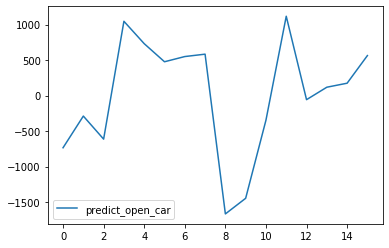

In [22]:
# 예측값 분포
submisson = pd.DataFrame()
submisson['predict_open_car'] = preds_car
submisson.plot()

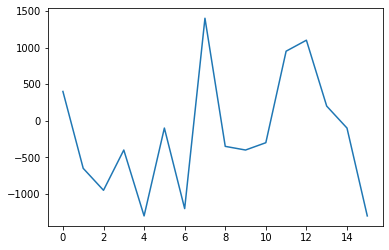

In [23]:
# 원래 데이터셋 분포
y_test.plot()

In [26]:
preds_car = preds_car.tolist()

c=0
for i in range(len(y_test)):
    c+=(preds_car[i]-y_test[i])**2
import math
rmse=math.sqrt(c/17)
rmse # 떡락

1072.6742101011016

### cf. 그 외 비정상성 보정 방법 : boxcox 변환

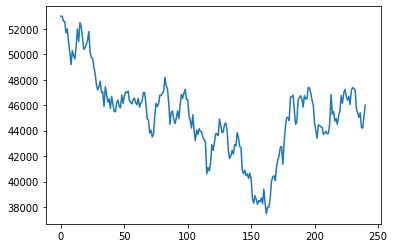

In [29]:
ss = wb.DataReader('005930.KS', 'yahoo', start, end)

from scipy.stats import boxcox
from scipy.special import inv_boxcox

# boxcox 변환
y = ss['Open']
y,fitted_lambda= boxcox(y,lmbda=None)
a=inv_boxcox(y,fitted_lambda)

import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(a.T )
plt.show()

**predict값 역차분**

y(t)의 차분 = y(t) - y(t-1)   
y(t) = y(t)의 차분 + y(t-1)    
따라서 첫번째항의 y(t-1)은 train 데이터셋에서 맨 마지막 행의 Open값을 가져옴.   

In [27]:

# predict_inverse = []
# for i in range(len(test_df)):
#     if i==0:
#         predict_inverse.append(test_df['predict_normal'].iloc[i] + train_df.Open.iloc[-1])
#     else:
#         predict_inverse.append(test_df['predict_normal'].iloc[i] + test_df['Open'].iloc[i-1])

NameError: name 'test_df' is not defined